# **✅ Bagian 1: Import dan Setup**

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

# Transformers
from transformers import AutoTokenizer, AutoModel, Trainer, TrainingArguments

# Sklearn
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)

# ✅ Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ✅ Tentukan path penyimpanan di Google Drive
my_drive_folder = "/content/drive/MyDrive/KlikBERT_Storage/IndoBERT/hard_parameter"

# ✅ Buat folder jika belum ada
os.makedirs(my_drive_folder, exist_ok=True)

# ✅ Ubah direktori kerja
os.chdir(my_drive_folder)

# ✅ Konfirmasi
print(f"✅ Current working directory set to: {os.getcwd()}")

# ✅ Cek CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")


Using device: cuda


#✅ Bagian 2: Load & Preprocess Dataset

In [ ]:
# Contoh untuk load
df = pd.read_csv("https://raw.githubusercontent.com/gikirima/indonews-scrapper/refs/heads/main/old%20dataset/KlikBERT_dataset.csv")
df = df.drop_duplicates().dropna()
print(f"Data shape after cleaning: {df.shape}")

# Label Encoding
from sklearn.preprocessing import LabelEncoder
le_clickbait = LabelEncoder()
le_kategori = LabelEncoder()

df["clickbait_label_encoded"] = le_clickbait.fit_transform(df["clickbait_label"])
df["kategori_label_encoded"] = le_kategori.fit_transform(df["kategori_berita"])

print("Clickbait labels:", le_clickbait.classes_)
print("Kategori labels:", le_kategori.classes_)


Data shape after cleaning: (4117, 5)
Clickbait labels: ['exaggeration' 'misleading' 'non clickbait' 'teasing']
Kategori labels: ['bisnis' 'entertainment' 'kesehatan' 'kriminal' 'lifestyle' 'lingkungan'
 'politik' 'sport' 'teknologi']


# ✅ Bagian 3: Split Train/Val/Test

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df["clickbait_label_encoded"], random_state=42
)
train_df, val_df = train_test_split(
    train_df, test_size=0.2, stratify=train_df["clickbait_label_encoded"], random_state=42
)

print(f"Train: {train_df.shape}, Val: {val_df.shape}, Test: {test_df.shape}")


Train: (2634, 7), Val: (659, 7), Test: (824, 7)


# ✅ Bagian 4: Tokenization

In [ ]:
model_name = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
max_len = 256

def tokenize_batch(df):
    return tokenizer(
        df["judul"].tolist(),
        df["isi"].tolist(),
        truncation=True,
        padding=True,
        max_length=max_len
    )

train_enc = tokenize_batch(train_df)
val_enc = tokenize_batch(val_df)
test_enc = tokenize_batch(test_df)


# **✅ Bagian 5: Dataset Class**

In [ ]:
class MultiTaskDataset(Dataset):
    def __init__(self, encodings, clickbait_labels, kategori_labels):
        self.encodings = encodings
        self.clickbait_labels = clickbait_labels
        self.kategori_labels = kategori_labels

    def __len__(self):
        return len(self.clickbait_labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["clickbait_labels"] = torch.tensor(self.clickbait_labels[idx], dtype=torch.long)
        item["kategori_labels"] = torch.tensor(self.kategori_labels[idx], dtype=torch.long)
        return item

train_dataset = MultiTaskDataset(
    train_enc,
    train_df["clickbait_label_encoded"].tolist(),
    train_df["kategori_label_encoded"].tolist()
)
val_dataset = MultiTaskDataset(
    val_enc,
    val_df["clickbait_label_encoded"].tolist(),
    val_df["kategori_label_encoded"].tolist()
)
test_dataset = MultiTaskDataset(
    test_enc,
    test_df["clickbait_label_encoded"].tolist(),
    test_df["kategori_label_encoded"].tolist()
)


# ✅ Bagian 6: Define Model

In [ ]:
class IndoBERTMultiTask(nn.Module):
    def __init__(self, model_name, num_clickbait_labels, num_kategori_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        hidden_size = self.bert.config.hidden_size
        self.dropout = nn.Dropout(0.3)
        self.clickbait_head = nn.Linear(hidden_size, num_clickbait_labels)
        self.kategori_head = nn.Linear(hidden_size, num_kategori_labels)

    def forward(self, input_ids, attention_mask, token_type_ids, clickbait_labels=None, kategori_labels=None):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled = output.last_hidden_state[:,0,:]
        pooled = self.dropout(pooled)
        clickbait_logits = self.clickbait_head(pooled)
        kategori_logits = self.kategori_head(pooled)

        loss = None
        loss_clickbait = None
        loss_kategori = None
        if clickbait_labels is not None and kategori_labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss_clickbait = loss_fct(clickbait_logits, clickbait_labels)
            loss_kategori = loss_fct(kategori_logits, kategori_labels)
            loss = loss_clickbait + loss_kategori

        return {
            "loss": loss,
            "loss_clickbait": loss_clickbait,
            "loss_kategori": loss_kategori,
            "clickbait_logits": clickbait_logits,
            "kategori_logits": kategori_logits
        }

model = IndoBERTMultiTask(
    model_name,
    num_clickbait_labels=len(le_clickbait.classes_),
    num_kategori_labels=len(le_kategori.classes_)
).to(device)


# ✅ Bagian 7: Trainer Setup

In [ ]:
class MultiTaskTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels_clickbait = inputs.pop("clickbait_labels")
        labels_kategori = inputs.pop("kategori_labels")
        outputs = model(**inputs, clickbait_labels=labels_clickbait, kategori_labels=labels_kategori)
        loss = outputs["loss"]
        # Log per-task loss
        self.log({
            "loss_clickbait": outputs["loss_clickbait"].detach().cpu().item(),
            "loss_kategori": outputs["loss_kategori"].detach().cpu().item()
        })
        return (loss, outputs) if return_outputs else loss

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="steps",
    eval_steps=50,
    save_steps=50,
    logging_dir="./logs",
    logging_steps=10,
    learning_rate=2e-5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

trainer = MultiTaskTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)


# ✅ Bagian 8: Train

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
50,2.081800,1.785923
100,1.665300,1.434872
150,1.536200,1.246987
200,1.315500,1.184996
250,1.209700,1.189000
300,1.129400,1.112232
350,0.950300,1.092354
400,0.834200,1.062402
450,0.804200,1.004850
500,0.723000,0.959525


TrainOutput(global_step=990, training_loss=0.9447585397296482, metrics={'train_runtime': 1584.2989, 'train_samples_per_second': 4.988, 'train_steps_per_second': 0.625, 'total_flos': 0.0, 'train_loss': 0.9447585397296482, 'epoch': 3.0})

# ✅ Bagian 9: Evaluation

In [ ]:
def get_predictions(trainer, dataset):
    loader = DataLoader(dataset, batch_size=8)
    all_clickbait = []
    all_kategori = []
    model.eval()
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            token_type_ids = batch["token_type_ids"].to(device)

            outputs = model(input_ids, attention_mask, token_type_ids)
            pred_clickbait = outputs["clickbait_logits"].argmax(dim=1).cpu().tolist()
            pred_kategori = outputs["kategori_logits"].argmax(dim=1).cpu().tolist()

            all_clickbait.extend(pred_clickbait)
            all_kategori.extend(pred_kategori)

    return all_clickbait, all_kategori

pred_clickbait, pred_kategori = get_predictions(trainer, test_dataset)
true_clickbait = test_df["clickbait_label_encoded"].tolist()
true_kategori = test_df["kategori_label_encoded"].tolist()

# Joint Accuracy
joint_correct = [
    (a == b) and (c == d)
    for a, b, c, d in zip(true_clickbait, pred_clickbait, true_kategori, pred_kategori)
]
joint_acc = np.mean(joint_correct)
print(f"✅ Joint Accuracy: {joint_acc:.4f}")


✅ Joint Accuracy: 0.6808


# ✅ Bagian 10: Metrics & Report

In [ ]:
def evaluate_task(true, pred, label_names, task_name):
    acc = accuracy_score(true, pred)
    print(f"\n✅ {task_name} Accuracy: {acc:.4f}")

    for avg in ['macro', 'micro', 'weighted']:
        f1 = f1_score(true, pred, average=avg)
        print(f" - {avg.capitalize()} F1: {f1:.4f}")

    # Per-class Precision, Recall, F1
    prec, rec, f1s, _ = precision_recall_fscore_support(true, pred)
    for i, label in enumerate(label_names):
        print(f"   {label}: Precision={prec[i]:.2f}, Recall={rec[i]:.2f}, F1={f1s[i]:.2f}")

    # Confusion Matrix
    cm = confusion_matrix(true, pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
    plt.title(f"{task_name} Confusion Matrix")
    plt.savefig(f"{task_name.lower().replace(' ','_')}_confusion_matrix.png")
    plt.close()

    # Classification Report
    report = classification_report(true, pred, target_names=label_names)
    print(report)
    with open(f"{task_name.lower().replace(' ','_')}_report.txt", "w") as f:
        f.write(report)

evaluate_task(true_clickbait, pred_clickbait, le_clickbait.classes_, "Clickbait")
evaluate_task(true_kategori, pred_kategori, le_kategori.classes_, "Kategori")



✅ Clickbait Accuracy: 0.7925
 - Macro F1: 0.7939
 - Micro F1: 0.7925
 - Weighted F1: 0.7939
   exaggeration: Precision=0.68, Recall=0.78, F1=0.73
   misleading: Precision=0.88, Recall=0.85, F1=0.87
   non clickbait: Precision=0.85, Recall=0.80, F1=0.82
   teasing: Precision=0.78, Recall=0.74, F1=0.76
               precision    recall  f1-score   support

 exaggeration       0.68      0.78      0.73       206
   misleading       0.88      0.85      0.87       206
non clickbait       0.85      0.80      0.82       206
      teasing       0.78      0.74      0.76       206

     accuracy                           0.79       824
    macro avg       0.80      0.79      0.79       824
 weighted avg       0.80      0.79      0.79       824


✅ Kategori Accuracy: 0.8471
 - Macro F1: 0.8309
 - Micro F1: 0.8471
 - Weighted F1: 0.8470
   bisnis: Precision=0.84, Recall=0.86, F1=0.85
   entertainment: Precision=0.89, Recall=0.89, F1=0.89
   kesehatan: Precision=0.85, Recall=0.81, F1=0.83
   krimi

# ✅ Bagian 11: Bias Analysis

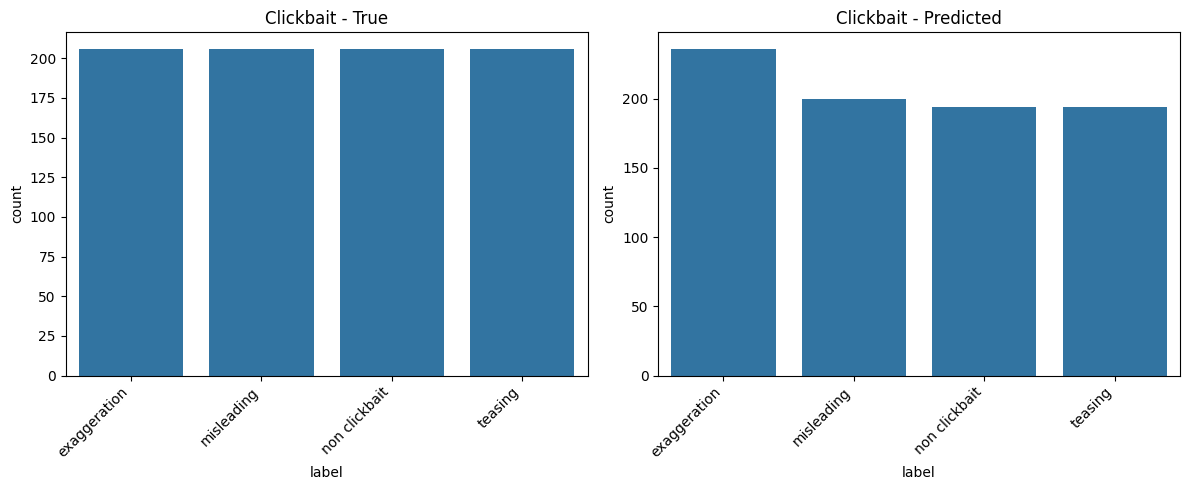

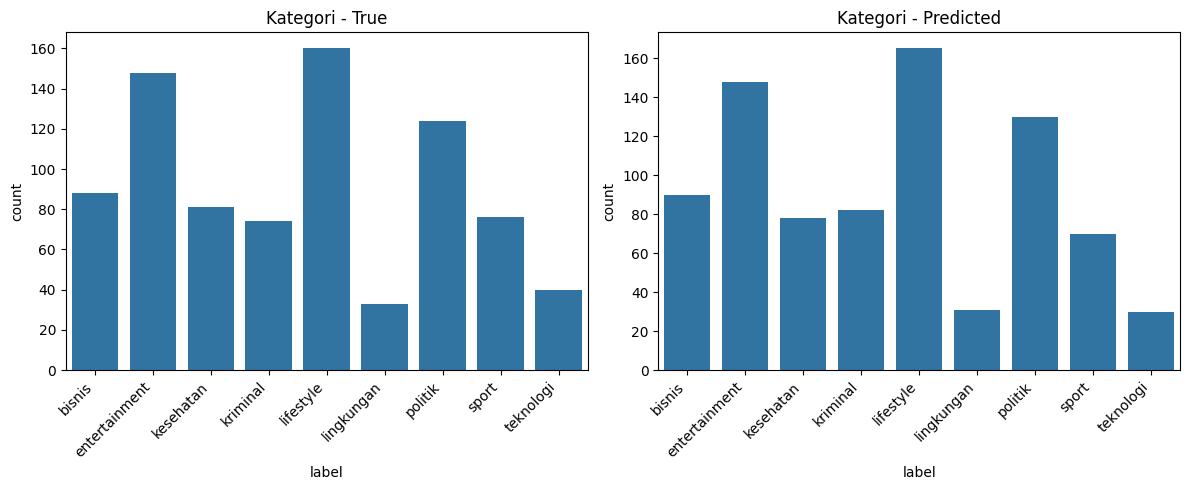

In [ ]:
def plot_label_distribution(true, pred, labels, title):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Pastikan true/pred terkonversi ke np.array
    true = np.array(true)
    pred = np.array(pred)

    # Buat count DataFrame supaya seaborn tahu semua kategori
    true_counts = pd.DataFrame({'label': true})
    pred_counts = pd.DataFrame({'label': pred})

    sns.countplot(x='label', data=true_counts, order=range(len(labels)), ax=axs[0])
    axs[0].set_title(f"{title} - True")
    axs[0].set_xticks(range(len(labels)))
    axs[0].set_xticklabels(labels, rotation=45, ha='right')

    sns.countplot(x='label', data=pred_counts, order=range(len(labels)), ax=axs[1])
    axs[1].set_title(f"{title} - Predicted")
    axs[1].set_xticks(range(len(labels)))
    axs[1].set_xticklabels(labels, rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig(f"{title.lower().replace(' ','_')}_distribution.png")
    plt.show()
    plt.close()


plot_label_distribution(true_clickbait, pred_clickbait, le_clickbait.classes_, "Clickbait")
plot_label_distribution(true_kategori, pred_kategori, le_kategori.classes_, "Kategori")

# ✅ Bagian 12: Simpan Model

In [ ]:
save_dir = "./saved_model"
os.makedirs(save_dir, exist_ok=True)
torch.save(model.state_dict(), os.path.join(save_dir, "pytorch_model.bin"))
tokenizer.save_pretrained(save_dir)
print(f"\n✅ Model and tokenizer saved in {save_dir}")

# ✅ Bagian 13: Simpan JSON

In [ ]:
import json

config = {
    "architectures": ["IndoBERTMultiTask"],
    "model_type": "indobert-multitask",
    "num_clickbait_labels": 4,
    "num_kategori_labels": 9,
    "_name_or_path": "indobenchmark/indobert-base-p1",
    "hidden_size": 768
}

with open(os.path.join(save_dir, "config.json"), "w") as f:
    json.dump(config, f, indent=2)